## Imports

In [1]:
import os
os.chdir('../')

In [2]:
import pickle
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import torch
from image_processing import *
from architecture import *

import matplotlib.pyplot as plt
import matplotlib
from binary_conv import BinConv2D

## Read models

Reading CIFAR-10 dataset with augmentation of the train set

In [3]:
dataloader = DatasetLoader(train_batch_size=256, test_batch_size=1000).load_cifar10()
test_loader = dataloader.get_testloader()
ntest = dataloader.get_ntest()

train_loader = dataloader.get_trainloader()

Loading All-CNN model with real-valued weights and activations

In [5]:
model = ConvolutionalNet().get_layers()
model.load_state_dict(torch.load("models/allcnn_model_120.pt", map_location=torch.device('cpu')))

converter = Converter(dataloader.get_trainloader(), dataloader.get_ntrain(), dataloader.get_testloader(), dataloader.get_ntest())
model = converter.eliminate_batchnorm(model)

Loading SBN version of the model above

In [26]:
sbn = torch.load("models/binary_allcnn.pt", map_location=torch.device('cpu'))
# sign_scale = pickle.load(open("data/sign_scales_final.pickle", 'rb'))

## Visualization of class distribution in 2D

In [27]:
sbn[2].shift.shape

torch.Size([96, 28, 28])

In [29]:
sbn_model = sbn[0:16]
allcnn_model = model[0:16]

In [30]:
sbn_model

Sequential(
  (0): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1))
  (1): LeakyReLU(negative_slope=0.01)
  (2): BinConv2D(96, 96, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (3): LeakyReLU(negative_slope=0.01)
  (4): BinConv2D(96, 96, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (5): LeakyReLU(negative_slope=0.01)
  (6): BinConv2D(96, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (7): LeakyReLU(negative_slope=0.01)
  (8): BinConv2D(192, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (9): LeakyReLU(negative_slope=0.01)
  (10): BinConv2D(192, 192, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (11): LeakyReLU(negative_slope=0.01)
  (12): BinConv2D(192, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (13): LeakyReLU(negative_slope=0.01)
  (14): BinConv2D(192, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (15): LeakyReLU(negative_slope=0.01)
)

In [11]:
i, _ = next(iter(test_loader))

In [15]:
test_forward = ForwardSample(n_samples=5, device=None)
x1 = test_forward.forward(sbn_model, i)

In [16]:
x0 = allcnn_model(i)

In [17]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init='pca', random_state=0)

In [18]:
x0.detach().numpy().shape

(1000, 192, 2, 2)

In [19]:
X_tsne = tsne.fit_transform(x0.detach().numpy().flatten().reshape(1000, 192*2*2))

In [21]:
X_tsne_bin = TSNE(n_components=2).fit_transform(test_forward.mean(x1).detach().numpy().flatten().reshape(1000, 192*2*2))

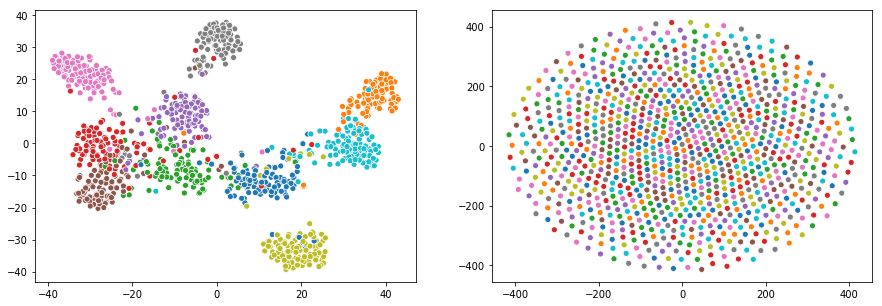

In [22]:
import seaborn as sns


fig, ax = plt.subplots(figsize=(15, 5), ncols=2)
g0 = sns.scatterplot(X_tsne[:, 0], X_tsne[:, 1], hue=_, palette="tab10", ax=ax[0])
g1 = sns.scatterplot(X_tsne_bin[:, 0], X_tsne_bin[:, 1], hue=_, palette="tab10", ax=ax[1])
ax[0].get_legend().remove()
ax[1].get_legend().remove();

## Visualization for all layers

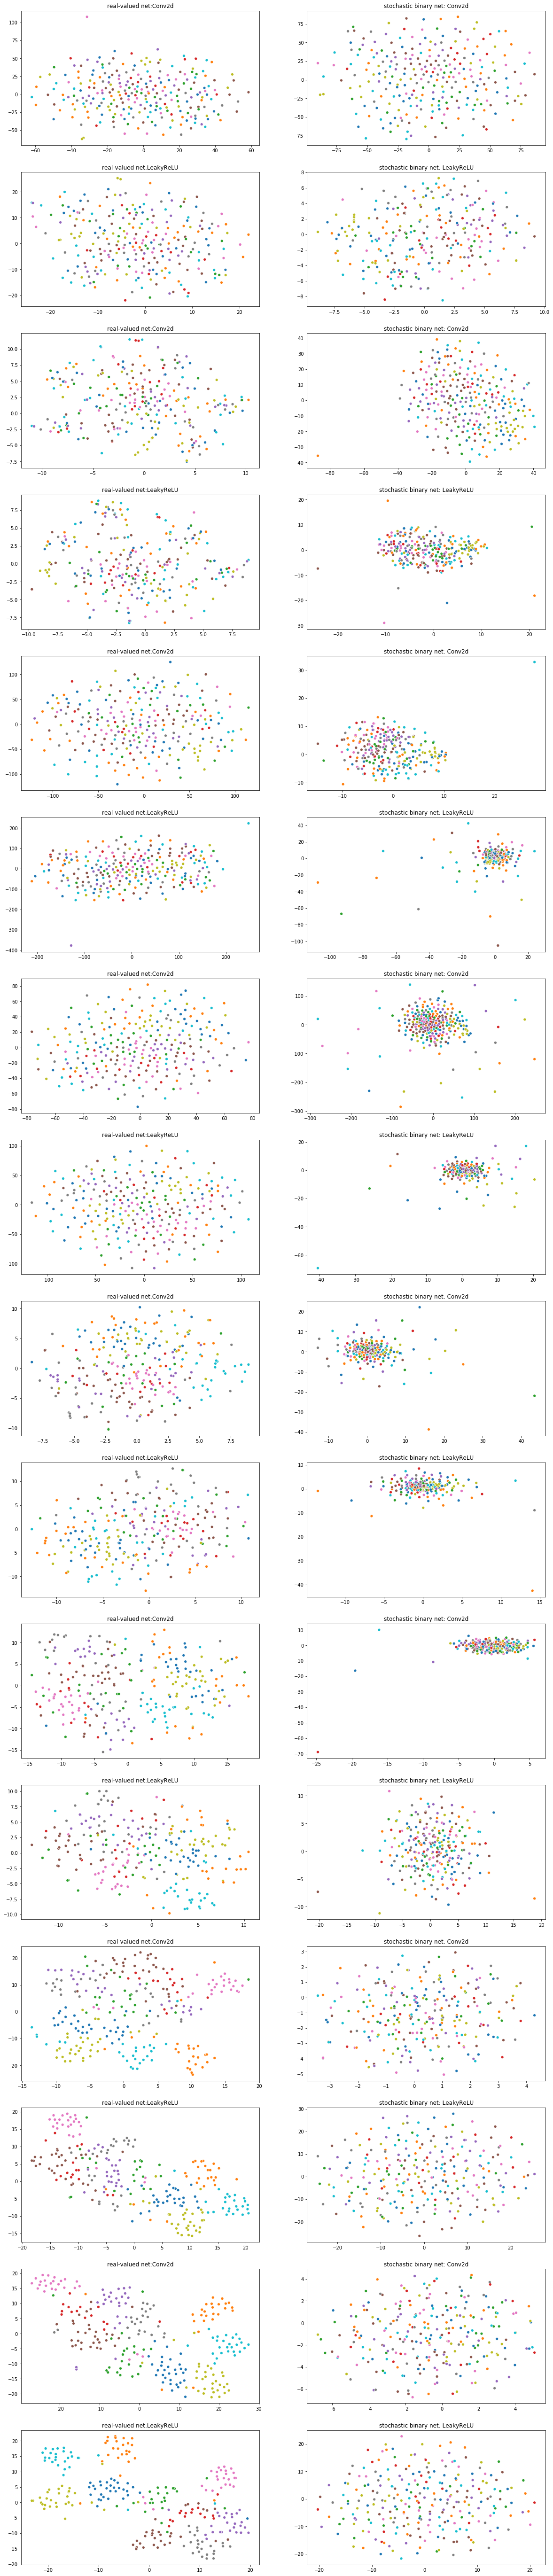

In [36]:
fig, ax = plt.subplots(nrows=len(allcnn_model), ncols =2, figsize=(20, 100))
linear_layer_index = 0
X0 = []
X1 = []

for i, (data, _) in enumerate(dataloader.get_trainloader()):
    x1, x0 = data, data
    sign_layer_index = -1

    for index in range(len(allcnn_model)):
        layer = allcnn_model[index]
        binlayer = sbn_model[index]

        if index == 0 or index == linear_layer_index:
            x1 = binlayer(x1)
            x0 = layer(x0)

        elif isinstance(layer, torch.nn.modules.conv.Conv2d):
            x0 = layer(x0)
            x1 = SBNFunctionality.binary_conv_forward(binlayer, x1)

        elif isinstance(layer, torch.nn.modules.activation.LeakyReLU):
            x0 = layer(x0)
            sign_layer_index += 1
            x1 = SBNFunctionality.sign_activation(x1, sign_scale[sign_layer_index])   

        else:
            x0 = layer(x0)
            x1 = binlayer(x1)
        
        x0_red = TSNE(n_components=2).fit_transform(x0.detach().numpy().flatten().reshape(x0.shape[0], x0.shape[1] * x0.shape[2] * x0.shape[3]))
        x1_red = TSNE(n_components=2).fit_transform(x1.detach().numpy().flatten().reshape(x0.shape[0], x0.shape[1] * x0.shape[2] * x0.shape[3]))
        
        X0.append(x0_red)
        X1.append(x1_red)
        
        sns.scatterplot(x0_red[:, 0], x0_red[:, 1], hue=_, palette="tab10", ax=ax[index, 0])
        sns.scatterplot(x1_red[:, 0], x1_red[:, 1], hue=_, palette="tab10", ax=ax[index, 1])
        ax[index, 0].get_legend().remove()
        ax[index, 1].get_legend().remove()
        ax[index, 0].set_title(f'real-valued net:{layer.__class__.__name__}')
        ax[index, 1].set_title(f'stochastic binary net: {layer.__class__.__name__}');
    break
    

plt.show()
    


        

## Histogram of probabilites in weights

In [9]:
sbn

Sequential(
  (0): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1))
  (1): LeakyReLU(negative_slope=0.01)
  (2): BinConv2D(96, 96, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (3): LeakyReLU(negative_slope=0.01)
  (4): BinConv2D(96, 96, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (5): LeakyReLU(negative_slope=0.01)
  (6): BinConv2D(96, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (7): LeakyReLU(negative_slope=0.01)
  (8): BinConv2D(192, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (9): LeakyReLU(negative_slope=0.01)
  (10): BinConv2D(192, 192, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (11): LeakyReLU(negative_slope=0.01)
  (12): BinConv2D(192, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (13): LeakyReLU(negative_slope=0.01)
  (14): BinConv2D(192, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (15): LeakyReLU(negative_slope=0.01)
  (16): Conv2d(192, 10, kernel_size=(1, 1), stride=(1, 1))
  (17): AdaptiveAvgPool2d(output_size=1)
  (18): F

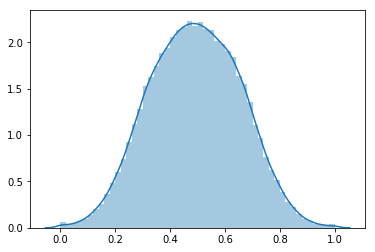

In [16]:
sns.distplot(layer.weight.data.detach().numpy().flatten())

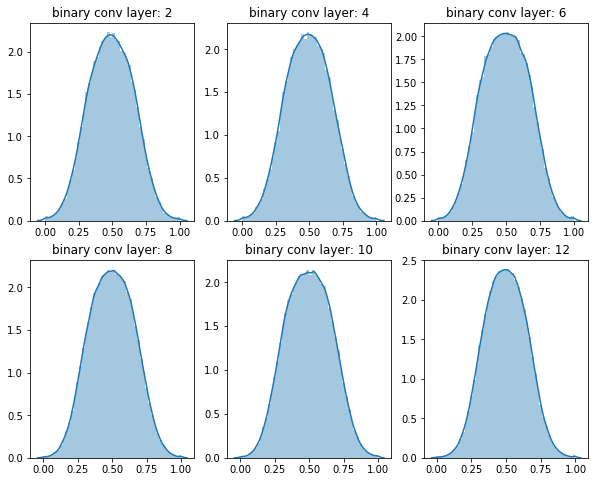

In [33]:
import seaborn as sns

fig, ax = plt.subplots(nrows=2, ncols =3, figsize=(10, 8))

index = 0
for i, layer in enumerate(sbn):
    if isinstance(layer, BinConv2D)  and index < 6:
        sns.distplot(layer.weight.data.detach().numpy().flatten(), ax=ax[index//3, index%3])
        ax[index//3, index%3].set_title(f"binary conv layer: {i}")
        index += 1
        

In [20]:
model

Sequential(
  (0): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1))
  (1): LeakyReLU(negative_slope=0.01)
  (2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1))
  (3): LeakyReLU(negative_slope=0.01)
  (4): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2))
  (5): LeakyReLU(negative_slope=0.01)
  (6): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1))
  (7): LeakyReLU(negative_slope=0.01)
  (8): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1))
  (9): LeakyReLU(negative_slope=0.01)
  (10): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2))
  (11): LeakyReLU(negative_slope=0.01)
  (12): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1))
  (13): LeakyReLU(negative_slope=0.01)
  (14): Conv2d(192, 192, kernel_size=(1, 1), stride=(1, 1))
  (15): LeakyReLU(negative_slope=0.01)
  (16): Conv2d(192, 10, kernel_size=(1, 1), stride=(1, 1))
  (17): AdaptiveAvgPool2d(output_size=1)
  (18): Flatten()
  (19): LogSoftmax(dim=1)
)

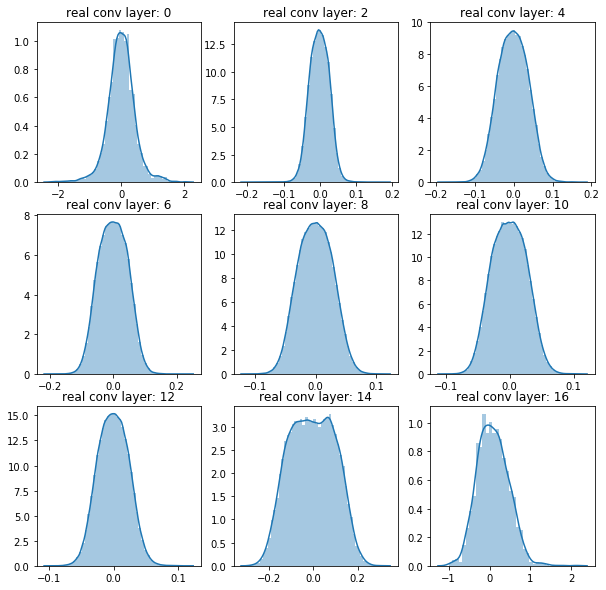

In [23]:
fig, ax = plt.subplots(nrows=3, ncols =3, figsize=(10, 10))

index = 0
for i, layer in enumerate(model):
    if isinstance(layer, nn.modules.conv.Conv2d):
        sns.distplot(layer.weight.data.detach().numpy().flatten(), ax=ax[index//3, index%3])
        ax[index//3, index%3].set_title(f"real conv layer: {i}")
        index += 1

In [27]:
model[2].weight.shape

torch.Size([96, 96, 3, 3])

In [59]:
from torchvision import utils

def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    n,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid((tensor), nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

        


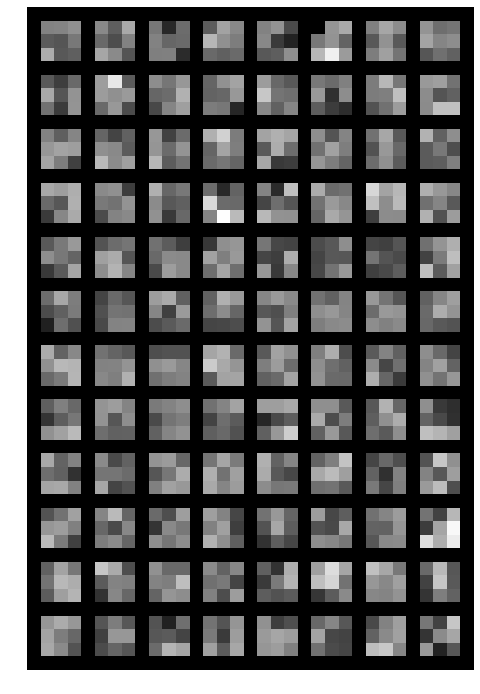

In [60]:
layer = 2
filter_cnn = model[layer].weight.data.clone()
visTensor(filter_cnn, ch=0, allkernels=False)

plt.axis('off')
plt.ioff()
plt.show()

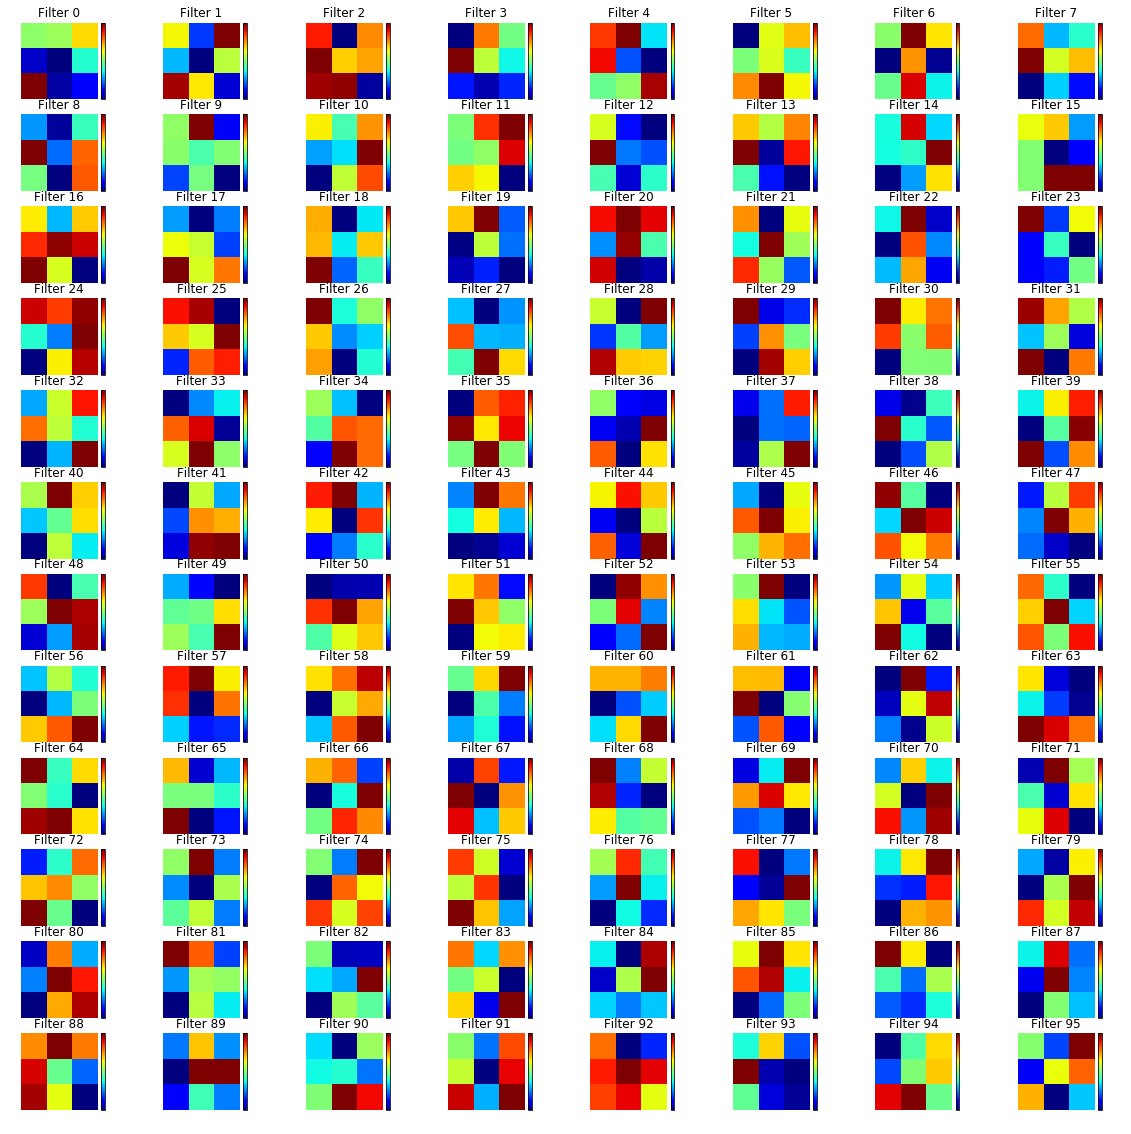

In [58]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

layer = model[2]
ncols = 8
nrows = int(layer.weight.shape[0] / ncols)

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))
for i, filt in enumerate(layer.weight):
    plt.sca(axs[i // ncols, i % ncols])
    weights = filt.detach().numpy()[0]
    # standardization to fit RGB [0, 1] values allowed
    standardized = (weights - np.min(weights)) / (np.max(weights) - np.min(weights))

    # image plotting
    im = plt.imshow(standardized)
    plt.axis('off')
    plt.title(f'Filter {i}')    
    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)
    plt.jet()
    plt.axis('off')

In [52]:
model[2].weight.shape[0] / 8

12.0